<a href="https://colab.research.google.com/github/Kavish1504/Probability-Density-Functions-using-data-only/blob/main/Assignment_4(Probability_Density_Function_using_data_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KernelDensity

In [20]:
df=pd.read_csv('data.csv',encoding="latin1")
df.head()

/tmp/ipython-input-1192858687.py:1: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data.csv',encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [21]:
df.dtypes

,0
stn_code,object
sampling_date,object
state,object
location,object
agency,object
type,object
so2,float64
no2,float64
rspm,float64
spm,float64


In [22]:
df["no2"] = pd.to_numeric(df["no2"])
df=df.dropna(subset=["no2"])
x=df["no2"].values.reshape(-1, 1)

In [23]:
df,x

(       stn_code       sampling_date           state   location agency  \
 0         150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
 1         151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
 2         152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
 3         150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
 4         151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
 ...         ...                 ...             ...        ...    ...   
 329892      NaN           16/6/2008       Rajasthan    Udaipur    NaN   
 329893      NaN           19/6/2008       Rajasthan    Udaipur    NaN   
 329894      NaN           23/6/2008       Rajasthan    Udaipur    NaN   
 329895      NaN           26/6/2008       Rajasthan    Udaipur    NaN   
 329896      NaN           30/6/2008       Rajasthan    Udaipur    NaN   
 
                                       type  so2   no2  rspm    spm  \
 0       Residential, Rural and other A

In [24]:
r=102317012
a_r=0.5*(r%7) #a_r=0
b_r = 0.3*(r%5+1)
z=x+a_r*np.sin(b_r*x)

In [25]:
a_r,b_r,z

(0.0,
 0.8999999999999999,
 array([[17.4],
        [ 7. ],
        [28.5],
        ...,
        [20.6],
        [20. ],
        [19.7]]))

In [26]:
z_mean=np.mean(z)
z_std=np.std(z)
z_norm=(z-z_mean)/z_std

In [27]:
gen=Sequential()
gen.add(Dense(32,activation="relu",input_dim=1))
gen.add(Dense(32, activation="relu"))
gen.add(Dense(1, activation="sigmoid"))
gen.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
disc=Sequential()
disc.add(Dense(32,activation="relu",input_dim=1))
disc.add(Dense(32,activation="relu"))
disc.add(Dense(1,activation="sigmoid"))
disc.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy"
)

In [29]:
disc.trainable=False
gan=Sequential()
gan.add(gen)
gan.add(disc)
gan.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy"
)

In [30]:
epochs=1500
batch_size=64

for epoch in range(epochs):
    idx=np.random.randint(0,z_norm.shape[0],batch_size)
    real_samples=z_norm[idx]
    noise=np.random.normal(0,1,(batch_size,1))
    fake_samples=gen.predict(noise,verbose=0)
    real_labels=np.ones((batch_size,1))
    fake_labels=np.zeros((batch_size,1))
    disc.train_on_batch(real_samples,real_labels)
    disc.train_on_batch(fake_samples,fake_labels)
    noise=np.random.normal(0, 1,(batch_size,1))
    gan.train_on_batch(noise,real_labels)

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


In [31]:
noise=np.random.normal(0, 1,(10000,1))
z_fake_norm=gen.predict(noise,verbose=0)

In [32]:
z_fake_norm=np.clip(
    z_fake_norm,
    z_norm.min(),
    z_norm.max()
)

In [33]:
kde=KernelDensity(kernel="gaussian",bandwidth=0.6)
kde.fit(z_fake_norm)
z_norm_range=np.linspace(
    z_norm.min(),
    z_norm.max(),
    500
).reshape(-1, 1)
pdf_vals=np.exp(kde.score_samples(z_norm_range))


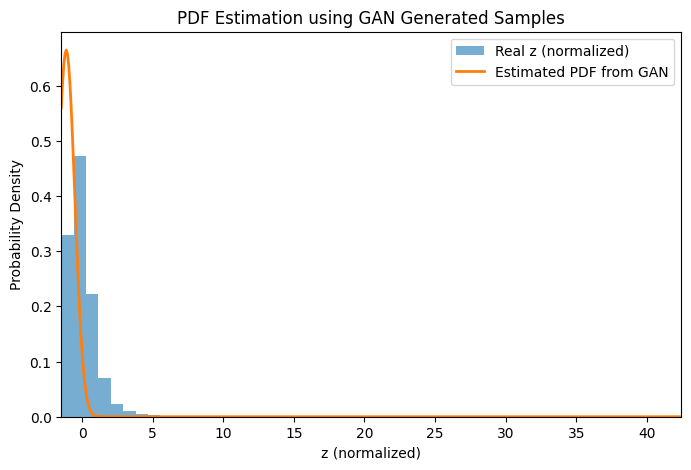

In [34]:
plt.figure(figsize=(8,5))
plt.hist(
    z_norm,
    bins=50,
    density=True,
    alpha=0.6,
    label="Real z (normalized)"
)
plt.plot(
    z_norm_range,
    pdf_vals,
    linewidth=2,
    label="Estimated PDF from GAN"
)
plt.xlim(z_norm.min(), z_norm.max())
plt.xlabel("z (normalized)")
plt.ylabel("Probability Density")
plt.title("PDF Estimation using GAN Generated Samples")
plt.legend()
plt.savefig("image.png",dpi=300,bbox_inches="tight")
plt.show()